# ViVAE workflow for cytometry data

This tutorial covers a simple ViVAE analysis pipeline for the Samusik bone marrow CyTOF dataset (DOI: [10.1038/nmeth.3863]((https://pubmed.ncbi.nlm.nih.gov/27183440/))) (from [HDCytoData](https://www.bioconductor.org/packages/release/data/experiment/html/HDCytoData.html)).

We demonstrate multiple layers of evaluation and interpretability.

In this notebook we will

- load and preprocess the expression data

- create a 2-dimensional embedding of the data using ViVAE and UMAP

- plot the mapping of manually labelled populations onto embedded points

- compute and plot encoder indicatrices for quantifying local distortions of the ViVAE latent space

- run a FlowSOM (meta)clustering on the original data and map the FlowSOM tree onto the ViVAE embedding

- use ViScore to asses local and global structure preservation and compare ViVAE to UMAP

<hr>

First let's load the required packages.
In addition to ViVAE, we will want the following...

FlowSOM for clustering:
```
pip install git+https://github.com/saeyslab/FlowSOM_Python.git@80529c6b7a1747e8e71042102ac8762c3bfbaa1b
```

UMAP as an alternative dimension-reduction method:
```
pip install umap-learn==0.5.5
```

ViScore for objective structure-preservation scoring:
```
conda install --channel conda-forge pyemd==1.0.0
pip install git+https://github.com/saeyslab/ViScore.git
```

In [1]:
import numpy as np
import torch
import ViVAE
import umap
import flowsom as fs
import ViScore

/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **1.** Data import and pre-processing

We first import our input FCS file and use an $arcsinh$ transformation for pre-processing of fluorophore signal.

In [2]:
ff       = fs.io.read_FCS(f'./cytometry_data/Samusik.fcs')
col_idcs = np.arange(8, 47) # column indices of markers of interest
ff       = ff[:,col_idcs]
cofactor = 5.
for channel in range(ff.shape[1]):
    ff[:,channel].X = np.arcsinh(ff[:,channel].X/cofactor)
exprs   = np.asarray(ff.X) # extracted expression data

We also have manually assigned cell labels available for this dataset.

In [3]:
labels   = np.load(f'./cytometry_data/Samusik_annot.npy', allow_pickle=True)

We will build a *k*-nearest-neighbour graph (*k*-NNG) and use it for data denoising.
We do this to boost local structure preservation in ViVAE downstream.

In [4]:
knn     = ViVAE.make_knn(x=exprs, fname=f'./cytometry_data/Samusik_knn.npy') # if k-NNG already exists, it is loaded
exprs_d = ViVAE.smooth(exprs, knn, k=100, coef=1., n_iter=1)

Loading k-NNG


### **2.** Dimensionality reduction

Next we will set up a ViVAE model: a parametric dimension-reduction model based on a regularised variational autoencoder (VAE).

We will train it to learn a non-linear transformation of our high-dimensional (HD) data into a lower-dimensional (LD) smooth latent space, achieving structure-preserving dimensionality reduction.

The training is done using a combined loss function consisting of three terms:

- **reconstruction error**: measures reconstruction of original data by decoder from LD representation sampled from the latent space

- **KL-divergence from latent prior**: divergence from isotropic Gaussian latent prior using reparametrisation to maintain a smooth latent space (read more [here](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important))

- **MDS (quartet) loss**: for joint optimisation of relative intra-quartet distances between repeatedly and randomly sampled points (see [SQuadMDS](https://dial.uclouvain.be/pr/boreal/object/boreal:264665) for original idea behind this); this gets a weight of 10 (vs. the other two errors)

There are loss options.
You can read about them in the documentation by running:
```
help(ViVAE.ViVAE)
```

Some tips on hyperparameter tuning:

- Increase number of epochs (`n_epochs`) for better convergence or decrease it for shorter running times.

- Increase batch size (`batch_size`) for faster training, decrease it for less memory usage.

- Optimiser parameters (`learning_rate` and `weight_decay`) can be increased to speed up training, at the risk of instability and sub-optimal solutions.

In [5]:
np.random.seed(42)
torch.manual_seed(42)
model = ViVAE.ViVAE(input_dim=exprs.shape[1], latent_dim=2)
model.fit(exprs_d, n_epochs=50)

Epoch 1/50	recon: 96.8389	kldiv: 12.2738	geom: 0.0000	egeom: 0.0000	mds: 162.9896
Epoch 2/50	recon: 17.3231	kldiv: 6.0887	geom: 0.0000	egeom: 0.0000	mds: 42.6698
Epoch 3/50	recon: 9.1806	kldiv: 4.0220	geom: 0.0000	egeom: 0.0000	mds: 27.8560
Epoch 4/50	recon: 5.9642	kldiv: 3.0339	geom: 0.0000	egeom: 0.0000	mds: 20.8128
Epoch 5/50	recon: 4.2739	kldiv: 2.4200	geom: 0.0000	egeom: 0.0000	mds: 16.5792
Epoch 6/50	recon: 3.3463	kldiv: 2.0151	geom: 0.0000	egeom: 0.0000	mds: 13.5861
Epoch 7/50	recon: 2.7173	kldiv: 1.7309	geom: 0.0000	egeom: 0.0000	mds: 11.7025
Epoch 8/50	recon: 2.2737	kldiv: 1.5111	geom: 0.0000	egeom: 0.0000	mds: 10.1616
Epoch 9/50	recon: 1.9552	kldiv: 1.3464	geom: 0.0000	egeom: 0.0000	mds: 9.0135
Epoch 10/50	recon: 1.7107	kldiv: 1.2093	geom: 0.0000	egeom: 0.0000	mds: 8.0706
Epoch 11/50	recon: 1.5204	kldiv: 1.0988	geom: 0.0000	egeom: 0.0000	mds: 7.3397
Epoch 12/50	recon: 1.3708	kldiv: 1.0109	geom: 0.0000	egeom: 0.0000	mds: 6.7684
Epoch 13/50	recon: 1.2401	kldiv: 0.9282	geom: 0.0

We can now easily obtain the 2-dimensional embedding of our dataset and plot it using a colour scheme for points based on the manually assigned cell populations we imported earlier.

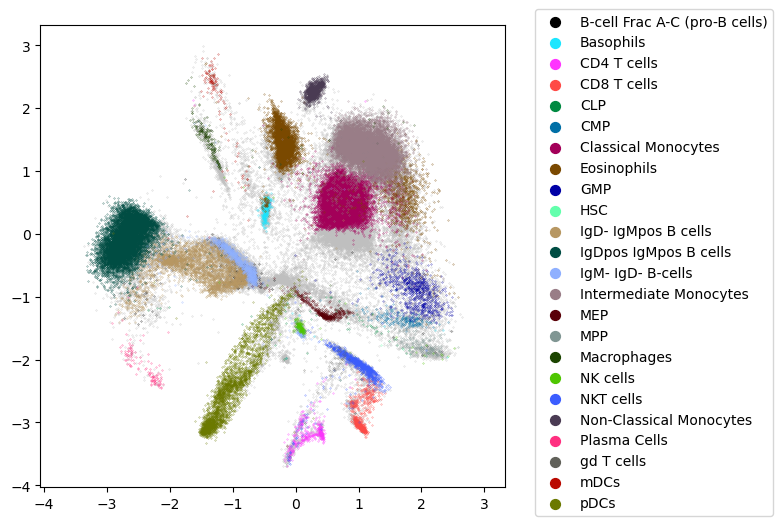

In [6]:
emb = model.transform(exprs_d)
ViVAE.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned')

### **3.** Integration with FlowSOM

FlowSOM is one of the go-to methods for analyses of cytometry datasets.
Thanks to this, many researchers are used to interpreting the outputs of FlowSOM analyses.
If you are one of them, you can apply a FlowSOM analysis to the original expression data and see how concordant the ViVAE embedding is with your FlowSOM tree.

First, let's train a FlowSOM model using the imported FCS file.

In [7]:
fsom = fs.FlowSOM(ff, n_clusters=40, xdim=10, ydim=10, seed=42) # train FlowSOM model

2024-06-17 19:13:20.173 | DEBUG    | flowsom.main:__init__:84 - Reading input.
/Users/davidnovak/miniforge3/envs/ViVAE/lib/python3.11/site-packages/flowsom/main.py:166: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["pretty_colnames"] = np.asarray(pretty_colnames, dtype=str)
2024-06-17 19:13:20.185 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2024-06-17 19:13:24.235 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.


We can now check how the minimum spanning tree (MST) from FlowSOM maps onto our embedding.

It is easy to plot the composition of each cluster in terms of manually defined populations, the expression of one or more markers of interest in each cluster or the mapping of each node to its cluster/metacluster.

You can read about all the FlowSOM plotting options in the documentation:
```
help(ViVAE.plot_embedding)
```

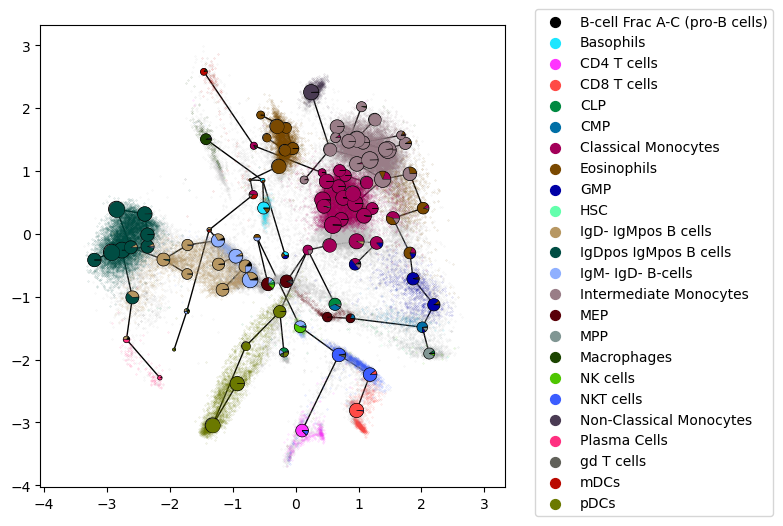

In [8]:
ViVAE.plot_embedding(embedding=emb, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model, fsom_edge_scale=1.) # show the FlowSOM tree mapping

### **4.** Encoder indicatrices

Furthermore, we compute and plot the encoder indicatrices, *ie.* objective indicators of local directed stretching of the latent space.
These are based on, but separate and different from, decoder indicatrices as implemented in *Geometric Autoencoders* (DOI: [arXiv:2306.17638](https://arxiv.org/abs/2306.17638)).

Indicatrices are small, equally large hyperspheres in the original, high-dimensional (HD) space (they lie in the [horizontal tangent spaces](https://gemini.google.com/share/9d567cee0c08) of existing data points).

As they are passed through the encoder, they can get distorted in two different ways.
Firstly, their size can vary across the embedding, including relative stretching or contraction of some parts of the points cloud.
Secondly, their shape can change (from sphere to ellipsis), which indicates the specific direction along which the distortion occurs.

In [9]:
ei_nice = model.encoder_indicatrices(X=exprs_d, radius=1e-3, n_steps=50, n_polygon=200)

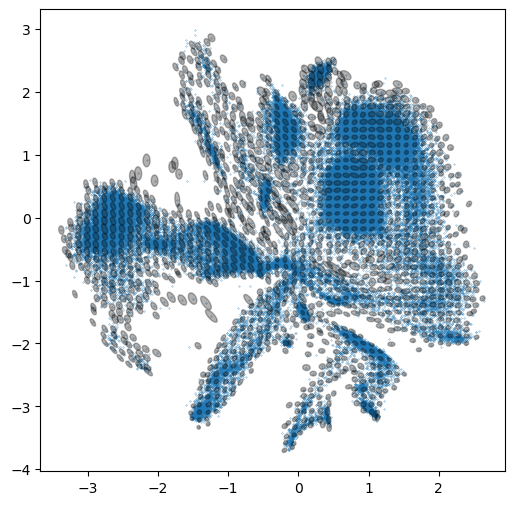

In [10]:
ViVAE.plot_indicatrices(indicatrices=ei_nice, scale_factor=8e1, figsize=(6,6))

The hyperspheres should have a small radius (`radius` in `model.encoder_indicatrices`), but not so small that the resulting shapes in the plot have sharp, as opposed to smooth, edges.

If the radius is set too large, the resulting plot may show a deformed elliptical, C-like or S-like shape in place of an ellipsis.

This is because the hyperspheres reach too far away from the data points and capture deformation outside the horizontal tangent space.
Such a visualisation is typically less informative.

In [11]:
ei_large = model.encoder_indicatrices(X=exprs_d, radius=1e2, n_steps=50, n_polygon=200)

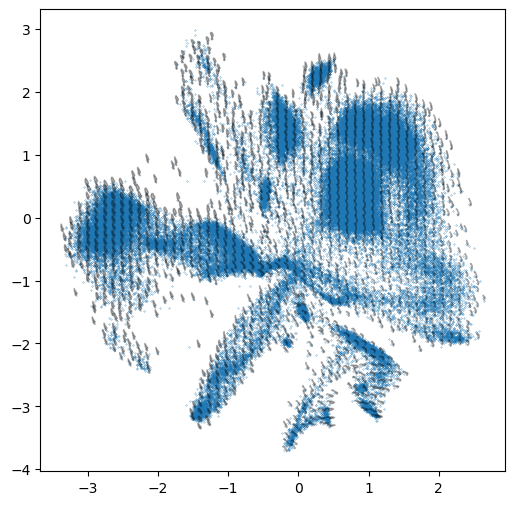

In [12]:
ViVAE.plot_indicatrices(indicatrices=ei_large, scale_factor=3e-3, figsize=(6,6))

If the radius is set too small, the edges of the hyperspheres will appear sharp, as opposed to smooth.

In [13]:
ei_small = model.encoder_indicatrices(X=exprs_d, radius=1e-6, n_steps=50, n_polygon=200)

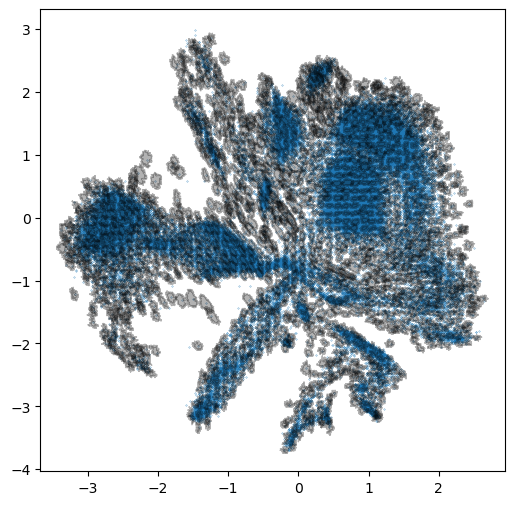

In [14]:
ViVAE.plot_indicatrices(indicatrices=ei_small, scale_factor=1e5, figsize=(6,6))

Note that the `scale_factor` in `plot_indicatrices` needs to be adapted for a good plot (*ie.* indicatrices should be plotted large enough to be informative, but small enough to not have too much overlap).

These are some additional arguments you can alter:

- `n_steps` in `encoder_indicatrices` determines the density of indicatrices (which are sampled on a grid). Higher values will ensure better coverage of the space, but cause a more cluttered plot.

- `n_polygon` in `encoder_indicatrices` determined how many points per indicatrix are sampled. Higher values will ensure higher-quality graphical output, but may increase running time if extremely high.

Note that encoder indicatrices can be implemented for any encoder (*ie.* differentiable dimension-reducing models).

### **5.** Objective evaluation of structure preservation

ViScore allow us to evaluate Local and Global Structure Preservation (SP).
This is achieved through accurate approximation of $R_{NX}$ curves, making it possible to measure multi-scale structure preservation in an objective manner, even for large datasets for which this was previously impossible.

Let's create a UMAP embedding of the same dataset and compare the performance of UMAP and of ViVAE.

In [15]:
model_umap = umap.UMAP()
model_umap.fit(exprs)
emb_umap = model_umap.transform(exprs)

The ViVAE plotting function can be used to display the UMAP embedding also.
Since this implementation of UMAP has a `.transform` method (*ie.* new points can be embedded into the latent space after training), we can even map the same FlowSOM tree onto the embedding as well.

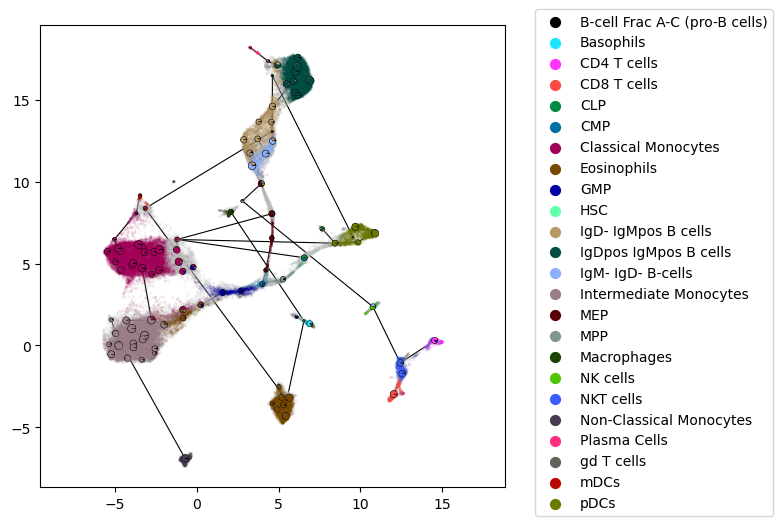

In [16]:
ViVAE.plot_embedding(emb_umap, labels=labels, unassigned='unassigned', fsom=fsom, dr_model=model_umap)

Finally, let's compute Local and Global Structure Preservation (SP) for the UMAP and the ViVAE embedding.

In [17]:
## Compare embeddings w.r.t. original input into each method
s_vivae = ViScore.score(hd=exprs, ld=emb)
s_umap  = ViScore.score(hd=exprs, ld=emb_umap)

In [18]:
## Report ViVAE and UMAP scores
print(f'ViVAE:\n\tLocal SP:\t{s_vivae["Sl"]:.3f}\n\tGlobal SP:\t{s_vivae["Sg"]:.3f}')
print(f'UMAP:\n\tLocal SP:\t{s_umap["Sl"]:.3f}\n\tGlobal SP:\t{s_umap["Sg"]:.3f}')

ViVAE:
	Local SP:	0.278
	Global SP:	0.621
UMAP:
	Local SP:	0.276
	Global SP:	0.493
